## RNN
- Embedding층은 단순하게 데이터의 표현을 학습하여 데이터 사전을 구축하는 것
- 하지만 유사한 의미의 단어를 비슷한 공간에 매핑할 수 있지만, 시퀀스 데이터의 중요한 특성인 순서와 맥락까지 고려한 것은 아니다.
- 순환신경망은 이 문제를 해결하기 위해 고안된 층

- 완전연결층, 컨볼루션 신경망의 반대되는 개념.
- 완전연결층과 컨볼루션 신경망은 피드 포워드 네트워크(feed-forward network)라고 표현
- 피드 포워드 네트워크는 신경망이 가지는 모든 출력값이 마지막층인 출력층을 향한다.
- 하지만 순환 신경망은 각 층의 결과값이 출력층을 향하면서도 동시에 현재층의 다음 계산에 사용된다.

### RNN셀
- 순환 신경망은 노드가 출력값을 반환하는 동시에 이전 상태를 기억하는 메모리 역할을 수행하는데 이를 RNN셀이라 한다.
- RNN셀의 상태를 은닉상태(hidden state)라고 한다.

![nn](KakaoTalk_20210109_123347044.jpg)

- 이전 시점의 은닉 상태를 참고하여 현재 시점의 상태를 만든다.
- 과거의 정보를 이용해서 현재 상태를 업데이트 한다.

## COS 데이터 만들기
- COS을 사용하여 시계열 데이터를 만드는 것

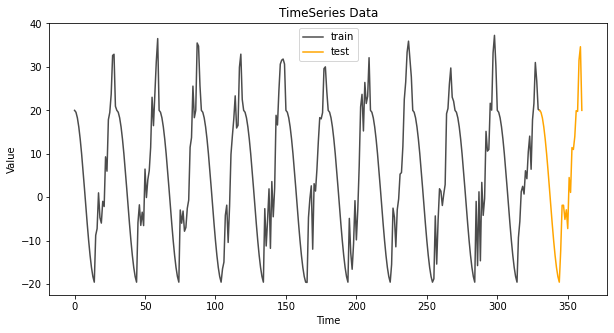

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5,
                           np.cos(2 * np.pi * month_time),
                           np.cos(2 * np.pi * month_time) + np.random.random(361)
                           )

plt.figure(figsize = (10, 5))
plt.title('TimeSeries Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color = 'black', alpha = 0.7, label = 'train') # 학습용데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color = 'orange', label = 'test') # 테스트용데이터
plt.legend()

plt.show()

## 시간적 순서가 존재하는 데이터를 만들기 위해 make_sequence 함수를 정의

In [7]:
def make_sequence(time_series, n):
    x_train, y_train = list(), list()
    
    for i in range(len(time_series)):
        x = time_series[i : (i+n)]
        if (i+n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i+n])
        else:
            break
            
    return np.array(x_train), np.array(y_train)

## 정의된 함수를 사용하여 데이터 전처리 수행하기

In [8]:
n = 10
x_train, y_train = make_sequence(time_series, n)

x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)

from sklearn.model_selection import train_test_split

patial_x_train = x_train[:30 * 11]
patial_y_train = y_train[:30 * 11]
x_test = x_train[30 * 11:]
y_test = y_train[30 * 11:]

print('train: ', patial_x_train.shape, patial_y_train.shape)
print('test: ', x_test.shape, y_test.shape)

train:  (330, 10, 1) (330, 1)
test:  (21, 10, 1) (21, 1)


## 데이터의 형태 확인하기

In [9]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 10)

for i in range(1, 4):
    print(a[i], '|', b[i])

[ 1  2  3  4  5  6  7  8  9 10] | 11
[ 2  3  4  5  6  7  8  9 10 11] | 12
[ 3  4  5  6  7  8  9 10 11 12] | 13


## SimpleRNN을 사용하여 모델 구성하기(여기부터 머신러닝 시작, 위까지는 데이터 만들기)
- SimpleRNN층을 첫 번째 층으로 사용하는 경우 반드시 input_shape를 명시해야 한다.
- units는 출력값의 차원.
- RNN에서는 주로 tanh(기본값)활성화 함수를 사용하거나 relu 활성화 함수를 사용한다.
- 여기서는 (n = 10, 1)을 사용 --> 10은 timesteps를 의미하며, 1은 데이터 특성의 개수

In [11]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n,1)))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


## 모델 학습하기
- 임의로 만든 데이터이기 때문에 학습이 빠르게 진행된다.
- `print()`: 학습 결과로 리턴된 history에서 확인할 수 있는 지표 출력
    - 학습과정을 확인할 때 그래프로 표시할 수 있는 항목이 출력된다.

In [12]:
hist = model.fit(x_train, y_train, epochs = 100, batch_size = 12)

Epoch 1/100
30/30 [==============================] - 0s 3ms/step - loss: 235.7332
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 196.7595
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 174.2308
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 157.3274
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 139.7163
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 122.5838
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 110.8703
Epoch 8/100
30/30 [==============================] - 0s 2ms/step - loss: 102.3636
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 94.8612
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 88.0435
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 81.6964
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 76.0385
Epoch 13/100
30/3

In [13]:
print(hist.history.keys())

dict_keys(['loss'])


## 예측 결과 그려보기

c:\users\youjin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\youjin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


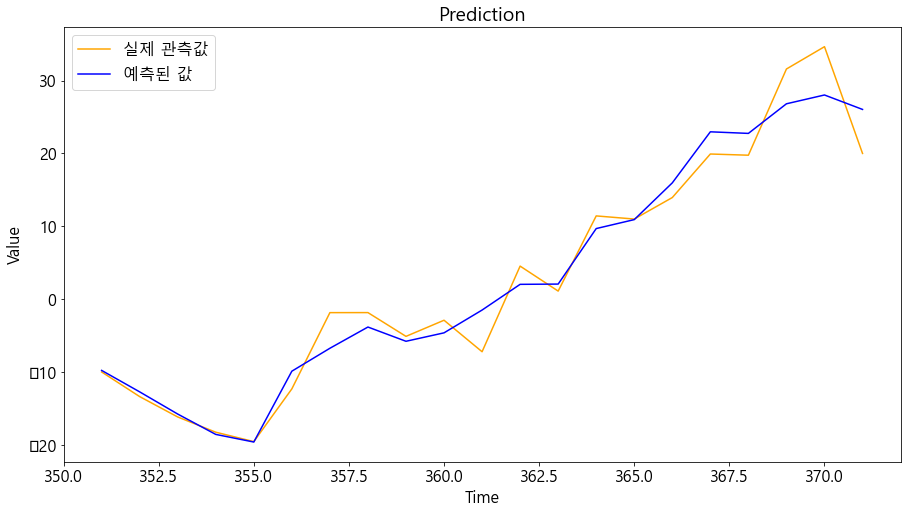

In [15]:
pred = model.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(pred))

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (15, 8)

plt.figure()
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1, ), color = 'orange', label = '실제 관측값')
plt.plot(pred_range, pred.reshape(-1, ), color = 'blue', label = '예측된 값')
plt.legend()

plt.show()